In [1]:
import numpy as np
import MDAnalysis as mda
import timeit
import matplotlib.pyplot as plt  
import copy
import scipy.special as sp

suw = mda.Universe("swater_prd.tpr","swater_prd.xtc")
uw = mda.Universe("water2_prd.tpr", "water2_prd.xtc")
uh = mda.Universe("hexaice_prd.tpr", "hexaice_prd.xtc")
uc = mda.Universe("cubicice_prd.tpr","cubicice_prd.xtc")

swbox = np.array([23.0, 23.0, 23.0])
wbox = np.array([30.0,   30.0,   30.0])
hbox = np.array([31.5251,   29.6340,   36.4161])
cbox = np.array([32.0350,   32.0350,   32.0350])

In [2]:
def cart2sph(x, y, z):
    r = np.sqrt(x*x+y*y+z*z)
    cos_theta = z/r
    theta = np.arccos(cos_theta)
    cos_phi = x/(np.sin(theta)*r)

    #Due to machine precision, sometimes cos_phi = +-1.0000001
    if cos_phi > 1:
        cos_phi = 1
    if cos_phi < -1:
        cos_phi = -1
    
    phi = np.arccos(cos_phi)
    if y < 0:
        phi = 2*np.pi-phi
    return theta, phi

In [3]:
#Let's get theta and phi between i and j
#for i = 0 j = 100 rij = r(j) - r(i)
def angle(i,j,o,box):
    ii = copy.copy(o[i])
    jj = copy.copy(o[j])

#     print(ii,jj)

    for k in range (3):
        if abs(ii[k]-jj[k]) > box[k]/2:
            if ii[k] > box[k]/2:
                jj[k] = jj[k] + box[k]
            else:
                jj[k] = jj[k] - box[k]

    h = jj-ii
#     print(jj-ii)
#     print(np.linalg.norm(h))
    theta, phi = cart2sph(h[0], h[1], h[2])
    return theta, phi

In [4]:
#Let's get q_lm(i)
#neighborlist (n,)
def steinhardt(m,l,i,neighborlist,o,box):
    n = neighborlist.size
    q_lm_i = 0
    for k in range(n):
        theta, phi = angle(i,np.intc(neighborlist[k]),o,box)
        a = sp.sph_harm(m,l,phi,theta)
        q_lm_i = a + q_lm_i
    q_lm_i = q_lm_i/n
    return q_lm_i

In [84]:
def orderparameter(pos_A, pos_B, box,x_max, n_bins, cutoff, l):
    
    o = pos_A
    N = o.shape[0] # number of molecules
    dist = np.abs(o[:, np.newaxis, :] - o)
    ddist = np.abs(dist - box)
    dist = np.minimum(dist, ddist)
    dist = np.reshape(dist*dist, (N*N,3))
    dist = np.sum(dist,axis = 1)
    dist = np.sqrt(dist)



    neighbor_list = []


    for i in range(N):
        distij = dist[i*(N):(i+1)*(N)] #make (N,) distance vector
        list = np.argsort(distij)
        distij = np.sort(distij)


        k = 1
        arr = []
        while distij[k] < cutoff:
            arr += [list[k]]
            k += 1
        arr = np.array(arr)
        neighbor_list += [arr]
        
    op = np.zeros((N,))
    for i in range(N):
        a = 0
        for k in range(-l,l+1):
            s = np.square(np.absolute(steinhardt(k,l,i,neighbor_list[i],o,box)))
            a = a + s
        op[i] = np.sqrt(4*np.pi/(2*l+1)*a)
    

    
    #binning step
    bins = np.linspace(0, x_max, n_bins)
    dr = bins[1] - bins[0]
    opp = np.sort(op)
    
    p = 0
    i = 0
    m = 0
    nr = np.zeros(n_bins)
    rdf = np.zeros(n_bins)

    while True:
        while opp[i] > bins[p]:
            nr[p] = m
            p = p+1
            if p== len(nr):
                break
        else:
            i = i+1
            m = m+1
            if i == len(opp):
                break
        if p == len(nr):
            break
            
    for i in range (n_bins-1):
        rdf[i+1] = nr[i+1] - nr[i]
        if rdf[i+1] <0:
            rdf[i+1] = rdf[i+1] + N
        
    

    return bins, rdf, op




In [85]:
bins, rdf, op = orderparameter(o, o, hbox, 1, 50, 3.5, 3)

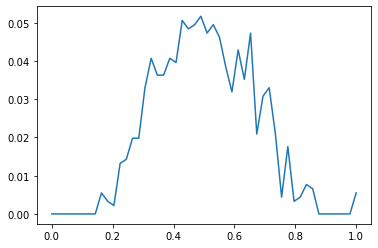

In [87]:
plt.plot(bins, rdf/909, label='water')

In [89]:
def op_average(u, array, fs_atom_name, sn_atom_name , box, x_max, n_bins, cutoff, l):

    '''
    Input:
      array(numpy.ndarray) : (n_time_frames)  ex) [0,100,200,300...,1000]
      
    output:
      bins(numpy.ndarray) : (n_bins,) array of bins
      gr_average(numpy.ndarray) : (n_bins, ) radial distribution function
      nr_average(numpy.ndarray) : (n_bins, ) number of cumulative molecules
    
    '''
    
    u.trajectory[0]
    p = u.select_atoms(fs_atom_name)
    o = p.atoms.positions
    N = o.shape[0] # number of molecules

    
    rdf__ = np.zeros(n_bins)
    opp = np.zeros((N,))
    n_bins = n_bins
    
    for i in array:
        u.trajectory[np.int(i)]
        p = u.select_atoms(fs_atom_name)
        pp = u.select_atoms(sn_atom_name)
        bins, rdf_, op = orderparameter(p.atoms.positions, pp.atoms.positions, box, x_max, n_bins, cutoff, l)
        rdf__ += rdf_
        opp += op

    
    return bins, rdf__/len(array), op#opp/len(array)

In [96]:
wbins, wrdf_, wop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 3)

In [97]:
hbins, hrdf_, hop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 3.5, 3)

In [98]:
cbins, crdf_, cop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 3.5, 3)

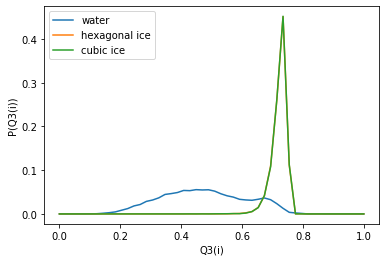

In [99]:
plt.plot(wbins, wrdf_/909, label='water')
plt.plot(hbins, hrdf_/1024, label='hexagonal ice')
plt.plot(cbins,crdf_/1000, label='cubic ice')
plt.xlabel("Q3(i)")
plt.ylabel("P(Q3(i))")

plt.legend()

In [100]:
wbins, wrdf_, wop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 4, 3)
hbins, hrdf_, hop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 4, 3)
cbins, crdf_, cop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 4, 3)

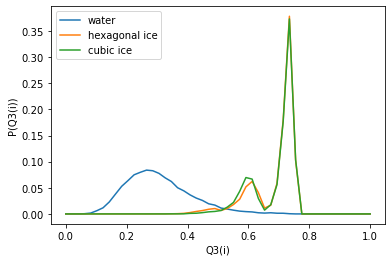

In [103]:
plt.plot(wbins, wrdf_/909, label='water')
plt.plot(hbins, hrdf_/1024, label='hexagonal ice')
plt.plot(cbins,crdf_/1000, label='cubic ice')
plt.xlabel("Q3(i)")
plt.ylabel("P(Q3(i))")

plt.legend()

In [104]:
wbins, wrdf_, wop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 3.5, 6)
hbins, hrdf_, hop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 3.5, 6)
cbins, crdf_, cop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 3.5, 6)

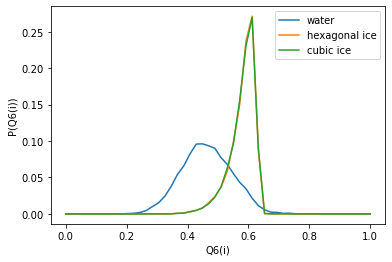

In [107]:
plt.plot(wbins, wrdf_/909, label='water')
plt.plot(hbins, hrdf_/1024, label='hexagonal ice')
plt.plot(cbins, crdf_/1000, label='cubic ice')
plt.xlabel("Q6(i)")
plt.ylabel("P(Q6(i))")


plt.legend()

In [108]:
wbins, wrdf_, wop = op_average(uw, np.linspace(0,250,20),"name OW", "name OW", wbox, 1, 50, 4, 6)
hbins, hrdf_, hop = op_average(uh, np.linspace(0,1000,20),"name OW", "name OW", hbox, 1, 50, 4, 6)
cbins, crdf_, cop = op_average(uc, np.linspace(0,1000,20),"name OW", "name OW", cbox, 1, 50, 4, 6)

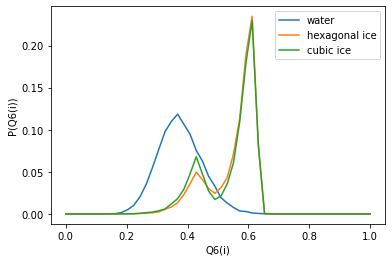

In [109]:
plt.plot(wbins, wrdf_/909, label='water')
plt.plot(hbins, hrdf_/1024, label='hexagonal ice')
plt.plot(cbins,crdf_/1000, label='cubic ice')
plt.xlabel("Q6(i)")
plt.ylabel("P(Q6(i))")


plt.legend()